In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
dirname = '/kaggle/input'
for filename in os.listdir(dirname):
    print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pixel-art


In [2]:
from typing import Dict, Tuple
from tqdm.autonotebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML
from torchvision.utils import save_image, make_grid
import os
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import math
import colorsys

/tmp/ipykernel_459/3293979228.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# use sinusoidal position embedding to encode time step (https://arxiv.org/abs/1706.03762)   
def timestep_embedding(timesteps, dim, max_period=500):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

In [4]:
class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        This class defines a generic one layer feed-forward neural network for embedding input data of
        dimensionality input_dim to an embedding space of dimensionality emb_dim.
        '''
        self.input_dim = input_dim
        
        # define the layers for the network
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        
        # create a PyTorch sequential model consisting of the defined layers
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # flatten the input tensor
        x = x.view(-1, self.input_dim)
        # apply the model layers to the flattened tensor
        return self.model(x)

In [5]:
class ContextEmbeddingBlock(nn.Module):
    def __init__(self, time_dim, context_dim, embed_dim):
        super().__init__()
        self.contextembed4 = EmbedFC(context_dim, 4 * embed_dim)
        self.contextembed3 = EmbedFC(context_dim, 2 * embed_dim)
        #self.contextembed0 = EmbedFC(context_dim, 8 * embed_dim)
        self.timeembed4 = EmbedFC(time_dim, 4 * embed_dim)
        self.timeembed3 = EmbedFC(time_dim, 2 * embed_dim)
        #self.timeembed0 = EmbedFC(time_dim, 8 * embed_dim)
    def forward(self, t_sin, c, device ,mask_c=None):
        c = c.float()
        if c is None:
            c = torch.zeros(t_sin.size(0), self.contextembed1.in_features).to(device)
        if mask_c is not None:
            c = c * mask_c.view(-1, 1)  # 遮蔽 c 條件向量
        
        cemb4 = self.contextembed4(c).view(t_sin.size(0), -1, 1, 1)
        temb4 = self.timeembed4(t_sin).view(t_sin.size(0), -1, 1, 1)
        cemb3 = self.contextembed3(c).view(t_sin.size(0), -1, 1, 1)
        temb3 = self.timeembed3(t_sin).view(t_sin.size(0), -1, 1, 1)
        return cemb4, temb4, cemb3, temb3

In [6]:
class SelfAttention2d(nn.Module):
    def __init__(self, dim, num_heads=4):
        super().__init__()
        self.norm = nn.BatchNorm2d(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        # x: [B, C, H, W] → flatten to [B, HW, C]
        B, C, H, W = x.shape
        x_ = self.norm(x).view(B, C, H*W).permute(0, 2, 1)  # [B, HW, C]
        attn_out, _ = self.attn(x_, x_, x_)
        attn_out = self.proj(attn_out)
        out = attn_out + x_  # skip connection
        out = out.permute(0, 2, 1).view(B, C, H, W)
        return out

In [7]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()

        #檢查in out 通道數是否相同
        self.same_channels = in_channels == out_channels

        # Flag for whether or not to use residual connection
        self.is_res = is_res

        # First convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

        # Second convolutional layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # If using residual connection
        if self.is_res:
            # Apply first convolutional layer
            x1 = self.conv1(x)

            # Apply second convolutional layer
            x2 = self.conv2(x1)

            # If input and output channels are the same, add residual connection directly
            if self.same_channels:
                out = x + x2
            else:
                # If not, apply a 1x1 convolutional layer to match dimensions before adding residual connection
                shortcut = nn.Conv2d(x.shape[1], x2.shape[1], kernel_size=1, stride=1, padding=0).to(x.device)
                out = shortcut(x) + x2
            #print(f"resconv forward: x {x.shape}, x1 {x1.shape}, x2 {x2.shape}, out {out.shape}")

            # Normalize output tensor
            return out / 1.414

        # If not using residual connection, return output of second convolutional layer
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

    # Method to get the number of output channels for this block
    def get_out_channels(self):
        return self.conv2[0].out_channels

    # Method to set the number of output channels for this block
    def set_out_channels(self, out_channels):
        self.conv1[0].out_channels = out_channels
        self.conv2[0].in_channels = out_channels
        self.conv2[0].out_channels = out_channels

In [8]:
class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        
        # Create a list of layers for the upsampling block
        # The block consists of a ConvTranspose2d layer for upsampling, followed by two ResidualConvBlock layers
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        
        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        # Concatenate the input tensor x with the skip connection tensor along the channel dimension
        x = torch.cat((x, skip), 1)
        
        # Pass the concatenated tensor through the sequential model and return the output
        x = self.model(x)
        return x

In [9]:
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        
        # Create a list of layers for the downsampling block
        # Each block consists of two ResidualConvBlock layers, followed by a MaxPool2d layer for downsampling
        layers = [ResidualConvBlock(in_channels, out_channels), ResidualConvBlock(out_channels, out_channels), nn.MaxPool2d(2)]
        
        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the sequential model and return the output
        return self.model(x)


In [10]:
def unorm(x):
    # unity norm. results in range of [0,1]
    # assume x (h,w,3)
    xmax = x.max((0,1))
    xmin = x.min((0,1))
    return(x - xmin)/(xmax - xmin)

def norm_all(store, n_t, n_s):
    # runs unity norm on all timesteps of all samples
    nstore = np.zeros_like(store)
    for t in range(n_t):
        for s in range(n_s):
            nstore[t,s] = unorm(store[t,s])
    return nstore

def norm_torch(x_all):
    # runs unity norm on all timesteps of all samples
    # input is (n_samples, 3,h,w), the torch image format
    x = x_all.cpu().numpy()
    xmax = x.max((2,3))
    xmin = x.min((2,3))
    xmax = np.expand_dims(xmax,(2,3)) 
    xmin = np.expand_dims(xmin,(2,3))
    nstore = (x - xmin)/(xmax - xmin)
    return torch.from_numpy(nstore)

def gen_tst_context(n_cfeat):
    """
    Generate test context vectors(class = 5)
    """
    vec = torch.tensor([
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0],      # human, non-human, food, spell, side-facing
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0],      # human, non-human, food, spell, side-facing
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0],      # human, non-human, food, spell, side-facing
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0],      # human, non-human, food, spell, side-facing
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0],      # human, non-human, food, spell, side-facing
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0]]      # human, non-human, food, spell, side-facing
    )
    return len(vec), vec

def plot_grid(x,n_sample,n_rows,save_dir,w):
    # x:(n_sample, 3, h, w)
    ncols = n_sample//n_rows
    grid = make_grid(norm_torch(x), nrow=ncols)  # curiously, nrow is number of columns.. or number of items in the row.
    save_image(grid, save_dir + f"run_image_w{w}.png")
    print('saved image at ' + save_dir + f"run_image_w{w}.png")
    return grid

def plot_sample(x_gen_store,n_sample,nrows,save_dir, fn,  w, save=False):
    ncols = n_sample//nrows
    sx_gen_store = np.moveaxis(x_gen_store,2,4)                               # change to Numpy image format (h,w,channels) vs (channels,h,w)
    nsx_gen_store = norm_all(sx_gen_store, sx_gen_store.shape[0], n_sample)   # unity norm to put in range [0,1] for np.imshow
    
    # create gif of images evolving over time, based on x_gen_store
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True,figsize=(ncols,nrows))
    def animate_diff(i, store):
        print(f'gif animating frame {i} of {store.shape[0]}', end='\r')
        plots = []
        for row in range(nrows):
            for col in range(ncols):
                axs[row, col].clear()
                axs[row, col].set_xticks([])
                axs[row, col].set_yticks([])
                plots.append(axs[row, col].imshow(store[i,(row*ncols)+col]))
        return plots
    ani = FuncAnimation(fig, animate_diff, fargs=[nsx_gen_store],  interval=200, blit=False, repeat=True, frames=nsx_gen_store.shape[0]) 
    plt.close()
    if save:
        ani.save(save_dir + f"{fn}_w{w}.gif", dpi=100, writer=PillowWriter(fps=5))
        print('saved gif at ' + save_dir + f"{fn}_w{w}.gif")
    return ani

In [11]:
class CustomDataset(Dataset):
    def __init__(self, sfilename, lfilename, transform, drop_p=0.1, null_context=False):
        self.sprites = np.load(sfilename)
        self.slabels = np.load(lfilename)
        print(f"sprite shape: {self.sprites.shape}")
        print(f"labels shape: {self.slabels.shape}")
        self.transform = transform
        self.null_context = null_context
        self.sprites_shape = self.sprites.shape
        self.slabel_shape = self.slabels.shape
        self.drop_p = drop_p
        #self.add_compute_color()
        self.color_classify()
        print(f"labels shape: {self.slabels.shape}")
        
    # Return the number of images in the dataset
    def __len__(self):
        return len(self.sprites)
    
    # Get the image and label at a given index
    def __getitem__(self, idx):
        # Return the image and label as a tuple
        if self.transform:
            image = self.transform(self.sprites[idx])
            label = torch.tensor(self.slabels[idx]).to(torch.int64)
        return (image, label)

    def getshapes(self):
        # return shapes of data and labels
        return self.sprites_shape, self.slabel_shape

    def add_compute_color(self, l_bound = 3, u_bound = 250):
        color_categories = {
            0: [(0, 30), (330, 360)],
            1: [(30, 60)],
            2: [(60, 120)],
            3: [(120, 180)],
            4: [(180, 240)],
            5: [(240, 270)],
            6: [(270, 330)],
            7: []  # 低飽和度或低明度的情況
        }
        N, H, W, C = self.sprites.shape
        add_label = np.zeros((N, len(color_categories)))
        mask_white = (self.sprites[...,0] == 255) & (self.sprites[...,1] == 255) & (self.sprites[...,2] == 255)
        mask_black = (self.sprites[...,0] == 0)   & (self.sprites[...,1] == 0)   & (self.sprites[...,2] == 0)
        mask = ~(mask_white | mask_black)
        mean_colors = np.mean(self.sprites, axis = (1, 2))
        for i in range(N):
            r, g, b = mean_colors[i][0] / 255, mean_colors[i][1] / 255, mean_colors[i][2] // 255
            h, s, v = colorsys.rgb_to_hsv(r, g, b)
            h_deg = h * 360  # 色相轉為角度 (0-360)
            # 判斷色系
            if s < 0.2 or v < 0.2:  # 低飽和度或低明度視為灰色
                color_label = 7
            else:
                color_label = 7  # 默認值
                for color, ranges in color_categories.items():
                    for h_min, h_max in ranges:
                        if h_min <= h_deg < h_max:
                            color_label = color
                            break
                    if color_label != 7:
                        break
            add_label[i][int(color_label)] = 1
        self.slabels = np.hstack((self.slabels, add_label))

    
    def color_classify(self):
        N, H, W, C = self.sprites.shape
        images = self.sprites.reshape(N, -1, 3)
        color_onehot = np.zeros((N, 7))
        for i in range(N):
            img = images[i]
            mask_white = (img[...,0] == 255) & (img[...,1] == 255) & (img[...,2] == 255)
            mask_black = (img[...,0] == 0)   & (img[...,1] == 0)   & (img[...,2] == 0)
            mask = ~(mask_white | mask_black)
            if not np.any(mask):
                # If no valid pixel (all white/black), classify color as gray (RGB)
                color_idx = 6
            else:
                # Calculate total R, G, B values for remaining pixels
                selected = img[mask]
                R_total = selected[:, 0].sum().astype(float)
                G_total = selected[:, 1].sum().astype(float)
                B_total = selected[:, 2].sum().astype(float)
                # Determine dominant color category:
                # Map for color_idx: 0=R, 1=G, 2=B, 3=RG, 4=RB, 5=GB, 6=RGB (gray)
                if R_total == G_total == B_total:
                    color_idx = 6  # all channels equal -> gray
                else:
                    vals = [R_total, G_total, B_total]
                    # Sort channel indices by their totals
                    sorted_idx = sorted(range(3), key=lambda i: vals[i])
                    min_idx, mid_idx, max_idx = sorted_idx[0], sorted_idx[1], sorted_idx[2]
                    max_val = vals[max_idx]; mid_val = vals[mid_idx]; min_val = vals[min_idx]
                    if max_val == 0:
                        color_idx = 6  # no color intensity -> gray
                    elif mid_val >= 0.9 * max_val and min_val >= 0.9 * max_val:
                        color_idx = 6  # all three channels approximately equal
                    elif mid_val >= 0.9 * max_val and min_val < 0.9 * max_val:
                        # Top two channels are close and higher than the third
                        pair = {max_idx, mid_idx}
                        if pair == {0, 1}:
                            color_idx = 3  # R≈G > B
                        elif pair == {0, 2}:
                            color_idx = 4  # R≈B > G
                        elif pair == {1, 2}:
                            color_idx = 5  # G≈B > R
                    else:
                        # One channel dominates
                        color_idx = max_idx  # 0 (R), 1 (G), or 2 (B)
            # Create one-hot vectors for class and color
            color_onehot[i][color_idx] = 1.0
            # Combine into 12-dim multi-label vector
        label_vec = np.hstack((self.slabels, color_onehot))
        self.slabels = label_vec

transform = transforms.Compose([
    transforms.ToTensor(),                # from [0,255] to range [0.0,1.0]
    transforms.Normalize((0.5,), (0.5,))  # range [-1,1]

])

In [12]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10, height=28):
        super(ContextUnet, self).__init__()
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height

        # Encoder
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)
        
        self.down1 = UnetDown(n_feat, n_feat) #64
        self.down2 = UnetDown(n_feat, 2 * n_feat) #128
        
        #self.down3 = nn.Sequential(
        #    UnetDown(2 * n_feat, 4 * n_feat),
        #    SelfAttention2d(4 * n_feat)
        #)
        self.down3 = UnetDown(2 * n_feat, 4 * n_feat)
        
        #self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.GELU())
        
        self.to_vec = nn.Sequential(
            nn.AvgPool2d((2)),
            ResidualConvBlock(4 * n_feat, 4 * n_feat),
            SelfAttention2d(4 * n_feat),
            nn.GELU()
        )
        # Embedding block (時間 + 條件)
        self.embed = ContextEmbeddingBlock(n_feat, n_cfeat, n_feat)
        
        # Decoder
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(4 * n_feat, 4 * n_feat, kernel_size=2, stride=2),
            nn.GroupNorm(8, 4 * n_feat),
            nn.ReLU(),
            #SelfAttention2d(4 * n_feat),
        )
        
        self.up3 = UnetUp(8 * n_feat, 2 * n_feat) # 4n → 2n
        self.up2 = UnetUp(4 * n_feat, n_feat) # 2n → 1n
        self.up1 = UnetUp(2 * n_feat, n_feat) # 1n → 1n
        
        self.attn1 =  SelfAttention2d(n_feat)
        self.attn2 =  SelfAttention2d(n_feat)
        self.attn3 =  SelfAttention2d(2*n_feat)
        
        # Output
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )
        self.x_proj = nn.Conv2d(in_channels, n_feat, kernel_size=1)
        self.out_attn = SelfAttention2d(n_feat)
    def forward(self, x, t, c=None, mask_c=None):
        x_in = x
        x_proj = self.x_proj(x_in)
        x = self.init_conv(x) #64
        d1 = self.down1(x) #64
        d2 = self.down2(d1) #128
        d3 = self.down3(d2) #256
        hvec = self.to_vec(d3) #256
        # 時間 & 條件 embedding
        t_sin = timestep_embedding(t.squeeze(-1), dim=self.n_feat, max_period=10000)
        #cemb4, temb4, cemb3, temb3, cemb0, temb0 = self.embed(t_sin, c, x.device,mask_c)
        cemb0, temb0, cemb3, temb3  = self.embed(t_sin, c, x.device,mask_c)
        # 上採樣過程 + attention
        up0 = self.up0(hvec) #256
        cemb0 = F.interpolate(cemb0, size=up0.shape[-2:], mode='nearest')  # or 'bilinear'
        temb0 = F.interpolate(temb0, size=up0.shape[-2:], mode='nearest')
        up3 = self.up3(cemb0 * up0 + temb0, d3) #128
        
        cemb3 = F.interpolate(cemb3, size=up3.shape[-2:], mode='nearest')  # or 'bilinear'
        temb3 = F.interpolate(temb3, size=up3.shape[-2:], mode='nearest')
        
        up3 = self.attn3(up3) #128
        
        up2 = self.up2(cemb3 * up3 + temb3, d2) #64
        #up2 = self.attn2(up2) #64
        up1 = self.up1(up2, d1) #64
        #up1 = self.attn1(up1) #64
        concat = torch.cat((up1, x_proj), dim=1)
        out = self.out(concat)
        return out

In [13]:
# hyperparameters

# diffusion hyperparameters
timesteps = 500
Beta1 = 1e-4
Beta2 = 0.02

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 96 # 64 hidden dimension feature
n_cfeat = 12 # context vector is of size 5
height = 16 # 16x16 image
save_dir = '/kaggle/working/'

# training hyperparameters
batch_size = 100
lrate= 1e-4
n_class = 5

In [14]:
# beta schedule
def linear_beta_schedule(timesteps):
    scale = 1000 / timesteps
    beta1 = scale * Beta1
    beta2  = scale * Beta2
    b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
    return b_t[1:]

def sigmoid_beta_schedule(timesteps):
    betas = torch.linspace(-6, 6, timesteps)
    betas = torch.sigmoid(betas)/(betas.max()-betas.min())*(0.02-betas.min())/10
    return betas

def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype=torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

In [20]:
class GaussianDiffusion:
    def __init__(
        self,
        timesteps=500,
        beta_schedule='linear'
    ):
        self.timesteps = timesteps
        
        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        elif beta_schedule == 'sigmoid':
            betas = sigmoid_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')
        self.betas = betas
            
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)
        
        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)
        
        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # below: log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        #self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min =1e-20))
        self.posterior_log_variance_clipped = torch.log(
            torch.cat([self.posterior_variance[1:2], self.posterior_variance[1:]])
        )
        
        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev)
            * torch.sqrt(self.alphas)
            / (1.0 - self.alphas_cumprod)
        )
    
    # get the param of given timestep t
    def _extract(self, a, t, x_shape):
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out
    
    # forward diffusion (using the nice property): q(x_t | x_0)
    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    
    # Get the mean and variance of q(x_t | x_0).
    def q_mean_variance(self, x_start, t):
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance
    
    # Compute the mean and variance of the diffusion posterior: q(x_{t-1} | x_t, x_0)
    def q_posterior_mean_variance(self, x_start, x_t, t):
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped
    
    # compute x_0 from x_t and pred noise: the reverse of `q_sample`
    def predict_start_from_noise(self, x_t, t, noise):
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )
    
    # compute predicted mean and variance of p(x_{t-1} | x_t)
    def p_mean_variance(self, model, x_t, t, c, w, clip_denoised=True):
        device = next(model.parameters()).device
        batch_size = x_t.shape[0]
        # predict noise using model
        pred_noise_c = model(x_t, t, c, torch.ones(batch_size).int().to(device))
        pred_noise_none = model(x_t, t, c, torch.zeros(batch_size).int().to(device))
        pred_noise = (1+w)*pred_noise_c - w*pred_noise_none
        
        # get the predicted x_0: different from the algorithm2 in the paper
        x_recon = self.predict_start_from_noise(x_t, t, pred_noise)
        if clip_denoised:
            x_recon = torch.clamp(x_recon, min=-1., max=1.)
        model_mean, posterior_variance, posterior_log_variance = \
                    self.q_posterior_mean_variance(x_recon, x_t, t)
        return model_mean, posterior_variance, posterior_log_variance
        
    # denoise_step: sample x_{t-1} from x_t and pred_noise
    @torch.no_grad()
    def p_sample(self, model, x_t, t, c, w, clip_denoised=True):
        # predict mean and variance
        model_mean, _, model_log_variance = self.p_mean_variance(model, x_t, t,
                                                c, w, clip_denoised=clip_denoised)
        noise = torch.randn_like(x_t)
        # no noise when t == 0
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        # compute x_{t-1}= μ + σ * ε
        pred_img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred_img
    
    # denoise: reverse diffusion
    @torch.no_grad()
    def p_sample_loop(self, model, shape, n_class=5, w=2, mode='random', clip_denoised=True):
        batch_size = shape[0]
        device = next(model.parameters()).device
        
        # generate labels
        if mode == 'random':
            cur_y = torch.randint(0, n_class, (batch_size,)).to(device)
        elif mode == 'all':
            batch_size = n_class
            cur_y = torch.tensor([x for x in range(n_class)]*(batch_size//n_class), dtype=torch.long).to(device)
        else:
            cur_y = torch.ones(batch_size).long().to(device)*int(mode)

        cur_y = F.one_hot(cur_y, num_classes=n_class).float().to(device)
        # start from pure noise (for each example in the batch)
        img = torch.randn(shape, device=device)
        imgs = []
        for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
            img = self.p_sample(model, img, torch.full((batch_size,), i, device=device, dtype=torch.long), cur_y, w, clip_denoised)
            imgs.append(img.cpu().numpy())
        return imgs
    
    # sample new images
    @torch.no_grad()
    def sample(self, model, image_size, batch_size=100, channels=3, n_class=5, w=2, mode='random', clip_denoised=True):
        return self.p_sample_loop(model, (batch_size, channels, image_size, image_size), n_class, w, mode, clip_denoised)
    
    # use ddim to sample
    @torch.no_grad()
    def ddim_sample(
        self,
        model,
        image_size,
        batch_size=100,
        channels=3,
        ddim_timesteps=50,
        n_class = 5,
        color_class = 8,
        w = 2.0,
        mode= 'random',
        ddim_discr_method="uniform",
        ddim_eta=0.0,
        clip_denoised=True):
        # make ddim timestep sequence
        if ddim_discr_method == 'uniform':
            c = self.timesteps // ddim_timesteps
            ddim_timestep_seq = np.asarray(list(range(0, self.timesteps, c)))
        elif ddim_discr_method == 'quad':
            ddim_timestep_seq = (
                (np.linspace(0, np.sqrt(self.timesteps * .8), ddim_timesteps)) ** 2
            ).astype(int)
        else:
            raise NotImplementedError(f'There is no ddim discretization method called "{ddim_discr_method}"')
        # add one to get the final alpha values right (the ones from first scale to data during sampling)
        ddim_timestep_seq = ddim_timestep_seq + 1
        # previous sequence
        model.eval()
        ddim_timestep_prev_seq = np.append(np.array([0]), ddim_timestep_seq[:-1])
        
        device = next(model.parameters()).device

        if mode == 'all':
            batch_size = n_class * color_class
        
        # generate labels
        if mode == 'random':
            cur_y = torch.randint(0, n_class, (batch_size,)).to(device)
        elif mode == 'all':
            cur_y = torch.tensor([x // (batch_size // n_class) for x in range(batch_size)], dtype=torch.long).to(device)
        else:
            cur_y = torch.ones(batch_size).long().to(device)*int(mode)
        color = torch.tensor([i % color_class for i in range(batch_size)]).to(device)
        # color = torch.randint(0, color_class, (batch_size,)).to(device)
        # print(cur_y)
        # print(color)
        cur_y = F.one_hot(cur_y, num_classes=n_class).float().to(device)
        color = F.one_hot(color, num_classes=color_class).float().to(device)
        cur_y = torch.hstack((cur_y, color))
        # start from pure noise (for each example in the batch)
        sample_img = torch.randn((batch_size, channels, image_size, image_size), device=device)
        seq_img = [sample_img.cpu().numpy()]
        
        for i in tqdm(reversed(range(0, ddim_timesteps)), desc='sampling loop time step', total=ddim_timesteps):
            t = torch.full((batch_size,), ddim_timestep_seq[i], device=device, dtype=torch.long)
            prev_t = torch.full((batch_size,), ddim_timestep_prev_seq[i], device=device, dtype=torch.long)
            
            # 1. get current and previous alpha_cumprod
            alpha_cumprod_t = self._extract(self.alphas_cumprod, t, sample_img.shape)
            alpha_cumprod_t_prev = self._extract(self.alphas_cumprod, prev_t, sample_img.shape)
    
            # 2. predict noise using model
            pred_noise_c = model(sample_img, t, cur_y, torch.ones(batch_size).int().cuda())
            pred_noise_none = model(sample_img, t, cur_y, torch.zeros(batch_size).int().cuda())
            pred_noise = (1+w)*pred_noise_c - w*pred_noise_none
            
            # 3. get the predicted x_0
            pred_x0 = (sample_img - torch.sqrt((1. - alpha_cumprod_t)) * pred_noise) / torch.sqrt(alpha_cumprod_t)
            if clip_denoised:
                pred_x0 = torch.clamp(pred_x0, min=-1., max=1.)
            
            # 4. compute variance: "sigma_t(η)" -> see formula (16)
            # σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
            sigmas_t = ddim_eta * torch.sqrt(
                (1 - alpha_cumprod_t_prev) / (1 - alpha_cumprod_t) * (1 - alpha_cumprod_t / alpha_cumprod_t_prev))
            
            # 5. compute "direction pointing to x_t" of formula (12)
            pred_dir_xt = torch.sqrt(1 - alpha_cumprod_t_prev - sigmas_t**2) * pred_noise
            
            # 6. compute x_{t-1} of formula (12)
            x_prev = torch.sqrt(alpha_cumprod_t_prev) * pred_x0 + pred_dir_xt + sigmas_t * torch.randn_like(sample_img)

            sample_img = x_prev
            """
            if mode == 'all':
                seq_img.append(sample_img.cpu().numpy())
            """
        """    
        if mode == 'all':
            return seq_img
        else:
         """  
        return sample_img.cpu().numpy()
    
    # compute train losses
    def train_losses(self, model, x_start, t, c, mask_c):
        # generate random noise
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)
        predicted_noise = model(x_noisy, t, c, mask_c)
        loss = F.mse_loss(noise, predicted_noise)
        return loss

In [21]:
timesteps = 500

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# use MNIST dataset
dataset = CustomDataset("/kaggle/input/pixel-art/sprites.npy",
                        "/kaggle/input/pixel-art/sprites_labels.npy",
                        transform, null_context=False)
dataloader = DataLoader(dataset, batch_size=batch_size,
                        shuffle=True, num_workers=1)

# define model and diffusion
device = "cuda" if torch.cuda.is_available() else "cpu"
nn_model = ContextUnet(
    in_channels=3,
    n_feat=n_feat,
    n_cfeat=n_cfeat,
    height=height
)
nn_model.to(device)
optimizer = torch.optim.Adam(nn_model.parameters(), lr=lrate)
gaussian_diffusion = GaussianDiffusion(timesteps=timesteps,beta_schedule='cosine')

sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)
labels shape: (89400, 12)


In [17]:
'''
# load in model weights and set to eval mode
start_epoch = 0
resume_ckpt_path = "/kaggle/input/model400/model_epoch_400.pt" 
checkpoint = torch.load(resume_ckpt_path, map_location=device)
nn_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for param_group in optimizer.param_groups:
    param_group['lr'] = lrate
start_epoch = checkpoint['epoch'] + 1
'''

'\n# load in model weights and set to eval mode\nstart_epoch = 0\nresume_ckpt_path = "/kaggle/input/model400/model_epoch_400.pt" \ncheckpoint = torch.load(resume_ckpt_path, map_location=device)\nnn_model.load_state_dict(checkpoint[\'model_state_dict\'])\noptimizer.load_state_dict(checkpoint[\'optimizer_state_dict\'])\nfor param_group in optimizer.param_groups:\n    param_group[\'lr\'] = lrate\nstart_epoch = checkpoint[\'epoch\'] + 1\n'

In [22]:
def draw():
    ddim_generated_images = gaussian_diffusion.ddim_sample(nn_model, 16, batch_size=32, channels=3, ddim_timesteps=250, n_class=5, color_class=7,
                                                       w=2.0, mode='all', ddim_discr_method='quad', ddim_eta=0.0, clip_denoised=False)
    fig = plt.figure(figsize=(16, 16), constrained_layout=True)
    gs = fig.add_gridspec(5, 7)
    
    imgs = ddim_generated_images[:35]
    imgs = imgs.reshape(5, 7, 3, 16, 16)
    
    for n_row in range(5):
        for n_col in range(7):
            f_ax = fig.add_subplot(gs[n_row, n_col])
            img = imgs[n_row, n_col].transpose(1, 2, 0)  # [3,16,16] → [16,16,3]
            img = ((img + 1.0) * 127.5).clip(0, 255).astype(np.uint8)  # [-1,1] → [0,255]
            
            f_ax.imshow(img, interpolation='nearest')  # 保留像素風格
            f_ax.axis("off")
    plt.show()

  0%|          | 0/894 [00:00<?, ?it/s]

Epoch1/300	 Loss 0.1670	 Time 54.99


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

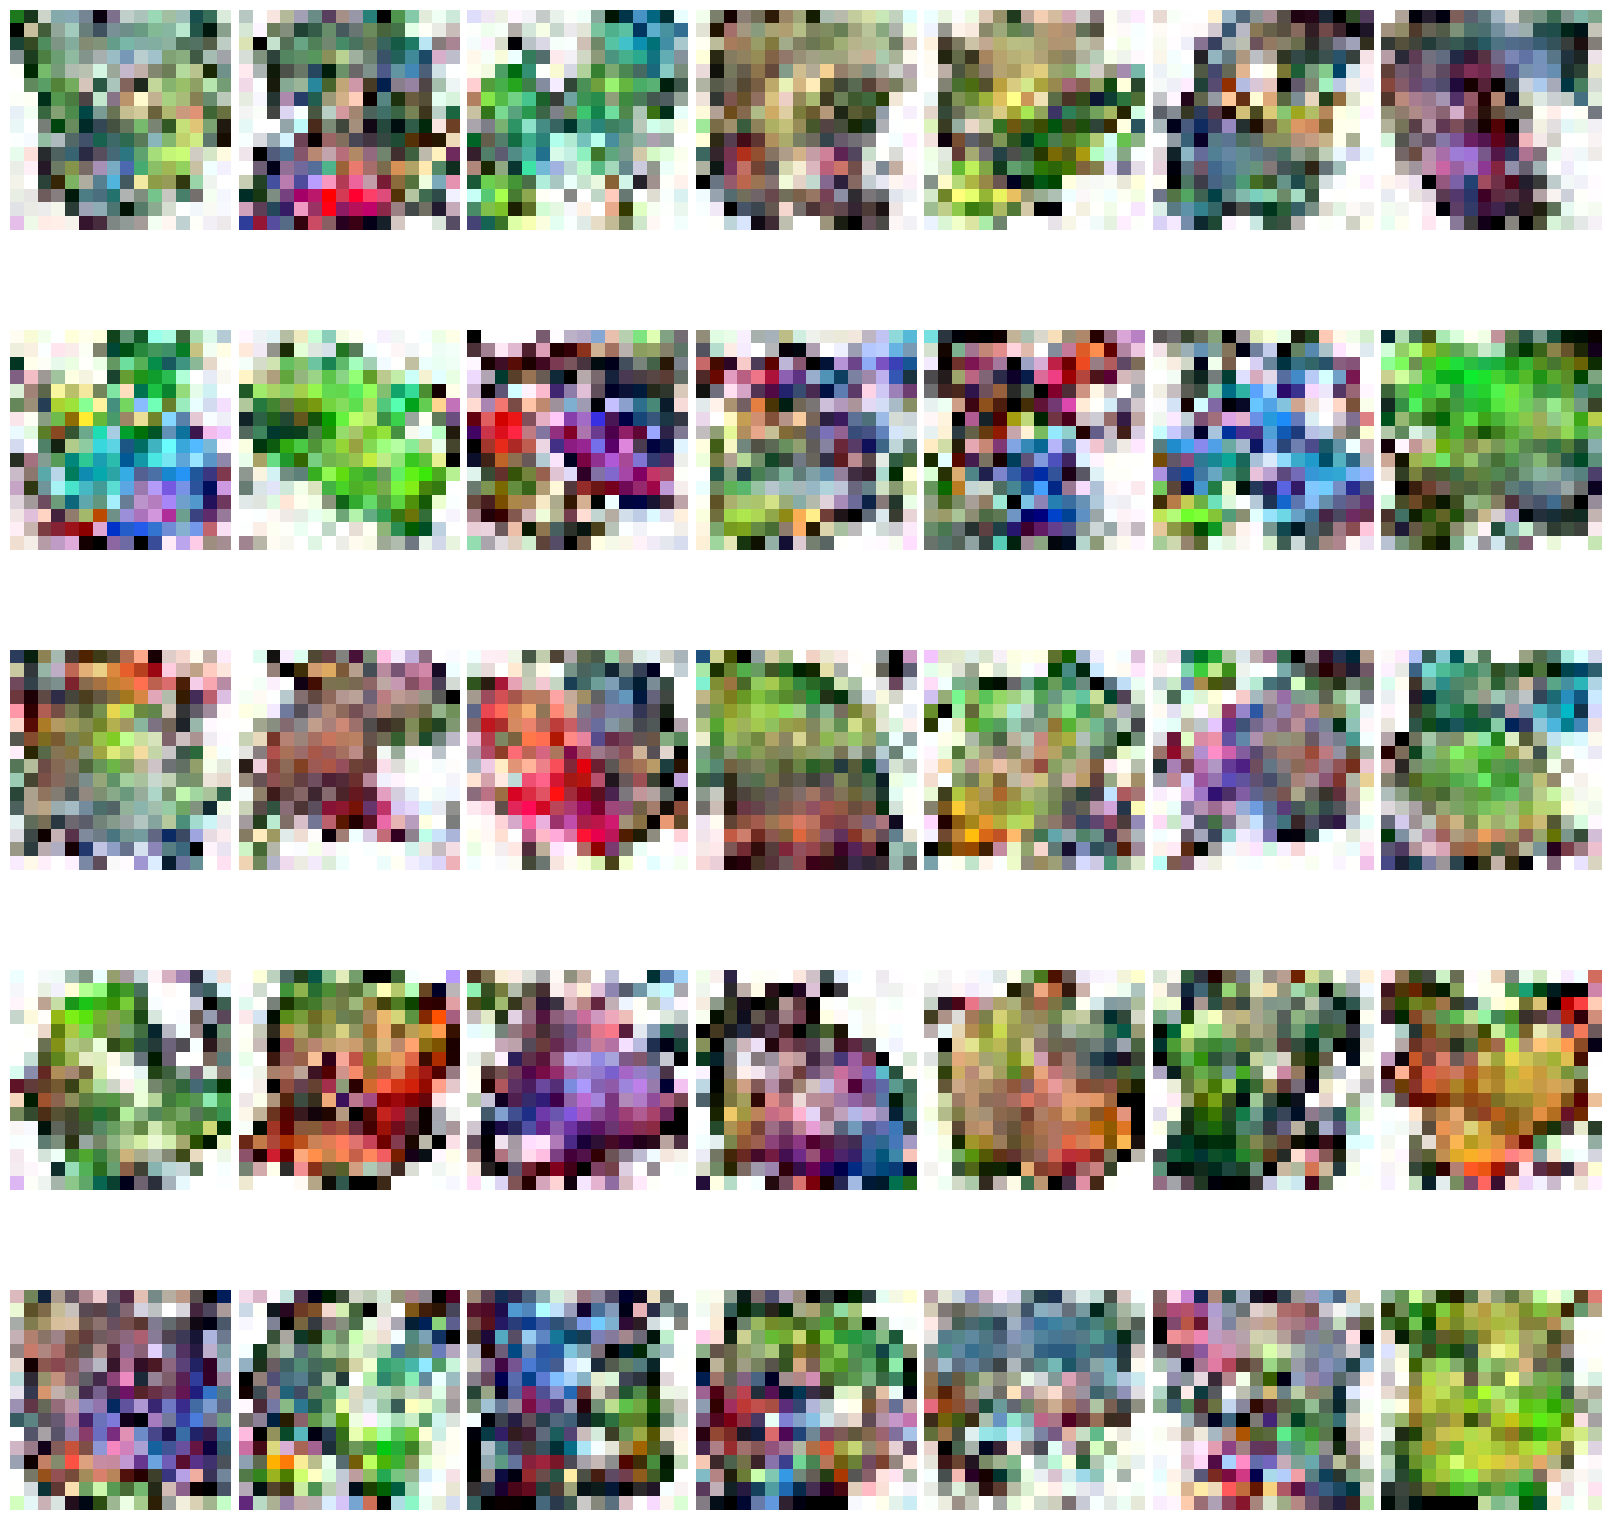

✅ Saved model at epoch 0 → ./checkpoints/model_epoch_0.pt


  0%|          | 0/894 [00:00<?, ?it/s]

Epoch2/300	 Loss 0.1465	 Time 54.93


  0%|          | 0/894 [00:00<?, ?it/s]

Epoch3/300	 Loss 0.1496	 Time 54.91


  0%|          | 0/894 [00:00<?, ?it/s]

Epoch4/300	 Loss 0.0901	 Time 54.93


  0%|          | 0/894 [00:00<?, ?it/s]

Epoch5/300	 Loss 0.0956	 Time 54.91


  0%|          | 0/894 [00:00<?, ?it/s]

Epoch6/300	 Loss 0.0961	 Time 54.92


  0%|          | 0/894 [00:00<?, ?it/s]

Epoch7/300	 Loss 0.0681	 Time 54.92


  0%|          | 0/894 [00:00<?, ?it/s]

Epoch8/300	 Loss 0.0853	 Time 54.92


  0%|          | 0/894 [00:00<?, ?it/s]

Epoch9/300	 Loss 0.0704	 Time 54.99


  0%|          | 0/894 [00:00<?, ?it/s]

Epoch10/300	 Loss 0.0519	 Time 55.02


  0%|          | 0/894 [00:00<?, ?it/s]

Epoch11/300	 Loss 0.0728	 Time 55.08


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

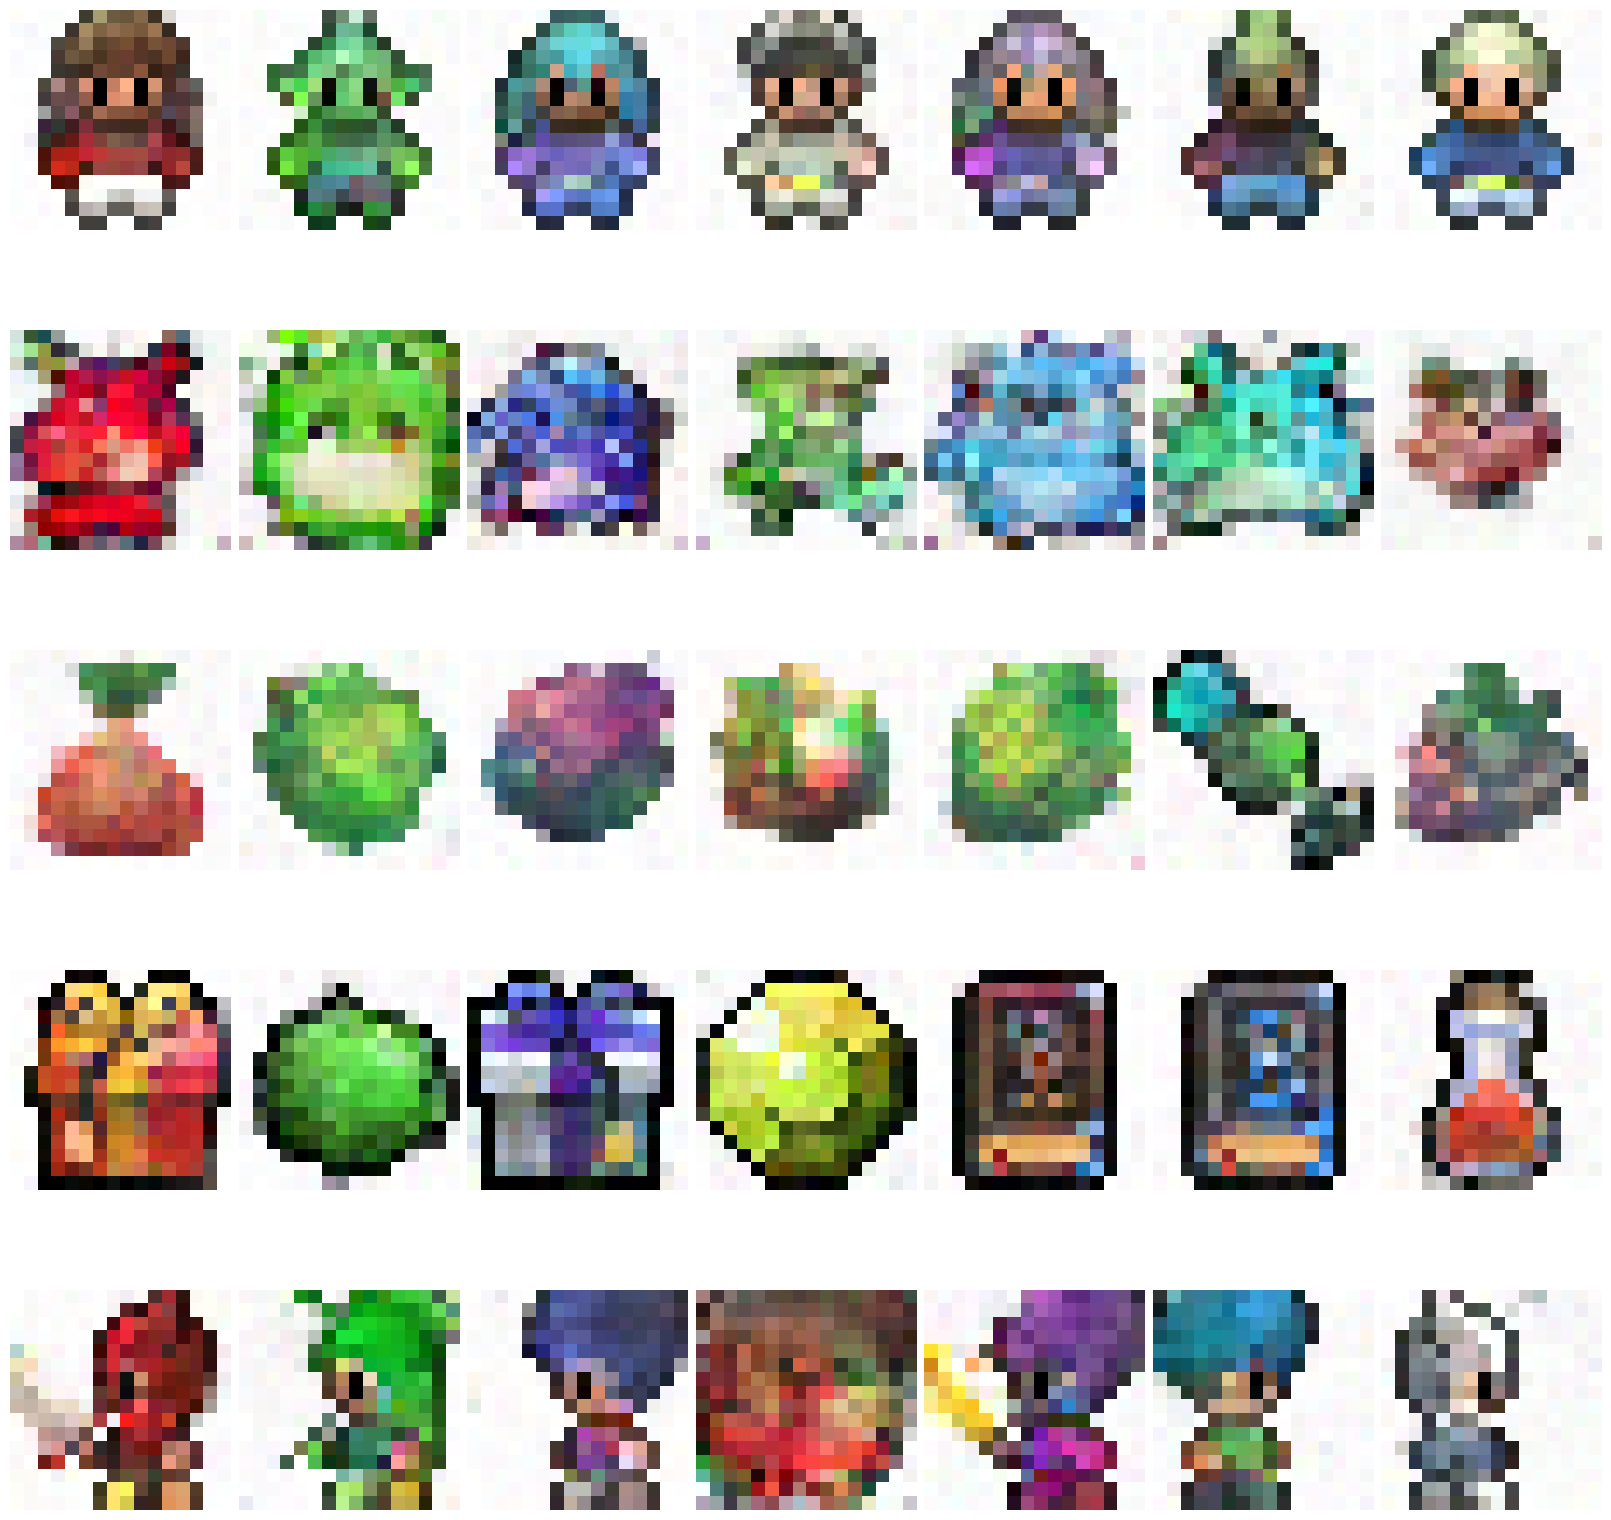

  0%|          | 0/894 [00:00<?, ?it/s]

Epoch12/300	 Loss 0.0806	 Time 55.08


  0%|          | 0/894 [00:00<?, ?it/s]

Epoch13/300	 Loss 0.0397	 Time 55.08


  0%|          | 0/894 [00:00<?, ?it/s]

Epoch14/300	 Loss 0.0707	 Time 55.06


  0%|          | 0/894 [00:00<?, ?it/s]

Epoch15/300	 Loss 0.0437	 Time 55.06


  0%|          | 0/894 [00:00<?, ?it/s]

Epoch16/300	 Loss 0.0424	 Time 55.05


  0%|          | 0/894 [00:00<?, ?it/s]

Epoch17/300	 Loss 0.0521	 Time 55.06


  0%|          | 0/894 [00:00<?, ?it/s]

Epoch18/300	 Loss 0.0490	 Time 55.09


  0%|          | 0/894 [00:00<?, ?it/s]

Epoch19/300	 Loss 0.0251	 Time 55.07


  0%|          | 0/894 [00:00<?, ?it/s]

Epoch20/300	 Loss 0.0580	 Time 55.06


  0%|          | 0/894 [00:00<?, ?it/s]

Epoch21/300	 Loss 0.0447	 Time 55.06


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

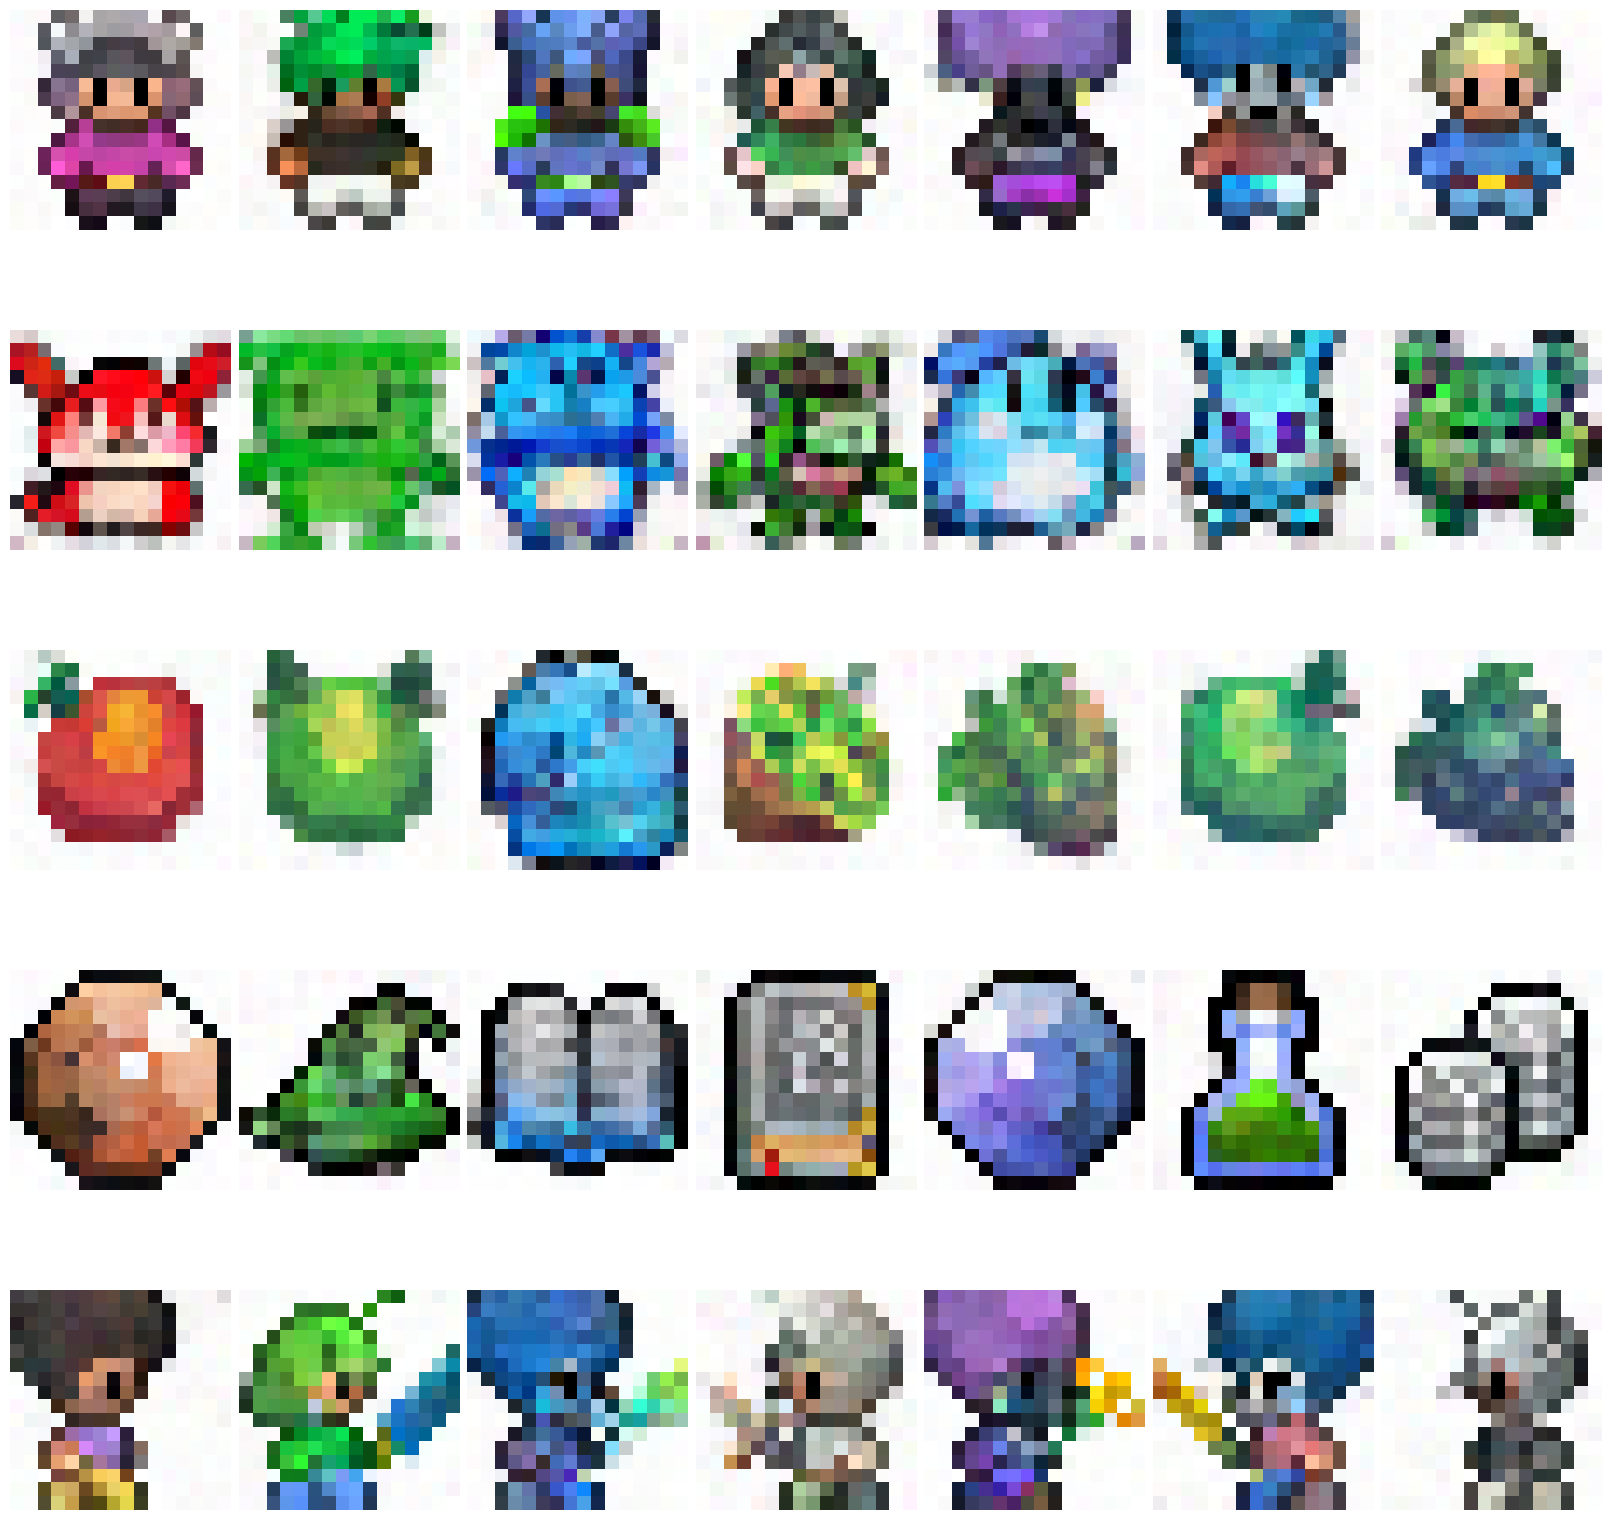

✅ Saved model at epoch 20 → ./checkpoints/model_epoch_20.pt


  0%|          | 0/894 [00:00<?, ?it/s]

Epoch22/300	 Loss 0.0522	 Time 55.07


  0%|          | 0/894 [00:00<?, ?it/s]

Epoch23/300	 Loss 0.0307	 Time 55.14


  0%|          | 0/894 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [23]:
import time
# train
epochs = 300
p_uncound = 0.15

len_data = len(dataloader)
time_end = time.time()

save_dir = "./checkpoints"
os.makedirs(save_dir, exist_ok=True)  # 確保資料夾存在

nn_model.train()
for epoch in range(epochs):
    time_start = time.time()
    nn_model.train()
    for (images, labels) in tqdm(dataloader):
        
        optimizer.zero_grad()
        
        batch_size = images.shape[0]
        images = images.to(device)
        labels = labels.to(device)
        
        # random generate mask
        z_uncound = torch.rand(batch_size)
        batch_mask = (z_uncound>p_uncound).float().to(device)
        
        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        loss = gaussian_diffusion.train_losses(nn_model, images, t, labels, batch_mask)
           
        loss.backward()
        optimizer.step()
    time_end = time.time()
    print("Epoch {}/{}\t Loss {:.4f}\t Time {:.2f}".format(epoch+1, epochs, loss.item(), time_end-time_start))
    if epoch % 10 == 0:    
        draw()
    if epoch % 20 == 0:
        save_path = os.path.join(save_dir, f"model_epoch_{epoch}.pt")
        torch.save({
            'epoch': epoch,
            'model_state_dict': nn_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, save_path)
        print(f"✅ Saved model at epoch {epoch} → {save_path}")

In [ ]:
checkpoint = torch.load("/kaggle/input/all-models/model_epoch_500.pt", map_location=device)
nn_model.load_state_dict(checkpoint['model_state_dict'])
nn_model.eval()
print("Loaded in Model")

In [ ]:
ddim_generated_images = gaussian_diffusion.ddim_sample(nn_model, 16, batch_size=32, channels=3, ddim_timesteps=100, n_class=5,
                                                       w=2.0, mode='1', ddim_discr_method='quad', ddim_eta=0.0, clip_denoised=False)

In [ ]:
# ddim generate new images
fig = plt.figure(figsize=(16, 16), constrained_layout=True)
gs = fig.add_gridspec(4, 8)

imgs = ddim_generated_images[:32]
imgs = imgs.reshape(4, 8, 3, 16, 16)

for n_row in range(4):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        img = imgs[n_row, n_col].transpose(1, 2, 0)  # [3,16,16] → [16,16,3]
        img = ((img + 1.0) * 127.5).clip(0, 255).astype(np.uint8)  # [-1,1] → [0,255]
        
        f_ax.imshow(img, interpolation='nearest')  # 保留像素風格
        f_ax.axis("off")

In [ ]:
ddim_generated_images = gaussian_diffusion.ddim_sample(nn_model, 16, batch_size=32, channels=3, ddim_timesteps=100, n_class=5,
                                                       w=2.0, mode='0', ddim_discr_method='quad', ddim_eta=0.0, clip_denoised=False)

In [ ]:

# ddim generate new images
fig = plt.figure(figsize=(16, 16), constrained_layout=True)
gs = fig.add_gridspec(4, 8)

imgs = ddim_generated_images[:32]
imgs = imgs.reshape(4, 8, 3, 16, 16)

for n_row in range(4):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        img = imgs[n_row, n_col].transpose(1, 2, 0)  # [3,16,16] → [16,16,3]
        img = ((img + 1.0) * 127.5).clip(0, 255).astype(np.uint8)  # [-1,1] → [0,255]
        
        f_ax.imshow(img, interpolation='nearest')  # 保留像素風格
        f_ax.axis("off")

In [ ]:
ddim_generated_images = gaussian_diffusion.ddim_sample(nn_model, 16, batch_size=32, channels=3, ddim_timesteps=100, n_class=5,
                                                       w=2.0, mode='4', ddim_discr_method='quad', ddim_eta=0.0, clip_denoised=False)

In [ ]:

# ddim generate new images
fig = plt.figure(figsize=(16, 16), constrained_layout=True)
gs = fig.add_gridspec(4, 8)

imgs = ddim_generated_images[:32]
imgs = imgs.reshape(4, 8, 3, 16, 16)

for n_row in range(4):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        img = imgs[n_row, n_col].transpose(1, 2, 0)  # [3,16,16] → [16,16,3]
        img = ((img + 1.0) * 127.5).clip(0, 255).astype(np.uint8)  # [-1,1] → [0,255]
        
        f_ax.imshow(img, interpolation='nearest')  # 保留像素風格
        f_ax.axis("off")

In [ ]:
ddim_generated_images = gaussian_diffusion.ddim_sample(nn_model, 16, batch_size=32, channels=3, ddim_timesteps=100, n_class=5,
                                                       w=2.0, mode='2', ddim_discr_method='quad', ddim_eta=0.0, clip_denoised=False)

In [ ]:

# ddim generate new images
fig = plt.figure(figsize=(16, 16), constrained_layout=True)
gs = fig.add_gridspec(4, 8)

imgs = ddim_generated_images[:32]
imgs = imgs.reshape(4, 8, 3, 16, 16)

for n_row in range(4):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        img = imgs[n_row, n_col].transpose(1, 2, 0)  # [3,16,16] → [16,16,3]
        img = ((img + 1.0) * 127.5).clip(0, 255).astype(np.uint8)  # [-1,1] → [0,255]
        
        f_ax.imshow(img, interpolation='nearest')  # 保留像素風格
        f_ax.axis("off")

In [ ]:
ddim_generated_images = gaussian_diffusion.ddim_sample(nn_model, 16, batch_size=32, channels=3, ddim_timesteps=100, n_class=5,
                                                       w=2.0, mode='3', ddim_discr_method='quad', ddim_eta=0.0, clip_denoised=False)

In [ ]:
# ddim generate new images
fig = plt.figure(figsize=(16, 16), constrained_layout=True)
gs = fig.add_gridspec(4, 8)

imgs = ddim_generated_images[:32]
imgs = imgs.reshape(4, 8, 3, 16, 16)

for n_row in range(4):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        img = imgs[n_row, n_col].transpose(1, 2, 0)  # [3,16,16] → [16,16,3]
        img = ((img + 1.0) * 127.5).clip(0, 255).astype(np.uint8)  # [-1,1] → [0,255]
        
        f_ax.imshow(img, interpolation='nearest')  # 保留像素風格
        f_ax.axis("off")

In [ ]:

gif_generated_images = gaussian_diffusion.ddim_sample(nn_model, 16, batch_size=100, channels=3, ddim_timesteps=100, n_class=5,
                                                       w=2.0, mode='all', ddim_discr_method='quad', ddim_eta=0.0, clip_denoised=False)

In [ ]:
fig = plt.figure(figsize=(16, 16), constrained_layout=True)
gs = fig.add_gridspec(4, 8)
print("Shape of gif_generated_images[-1]:", gif_generated_images[-1].shape)
print("Size of gif_generated_images[-1]:", gif_generated_images[-1].size)
imgs = gif_generated_images[-1][:32]
imgs = imgs.reshape(4, 8, 3, 16, 16)
for n_row in range(4):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        img = imgs[n_row, n_col].transpose(1, 2, 0)  # [3,16,16] → [16,16,3]
        img = ((img + 1.0) * 127.5).clip(0, 255).astype(np.uint8)  # [-1,1] → [0,255]
        
        f_ax.imshow(img, interpolation='nearest')  # 保留像素風格
        f_ax.axis("off")

In [ ]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib auto
import imageio
from glob import glob

# 生成gif
def get_imgs(x_seq, imgs_path, h, w, img_size):
    if not os.path.exists(imgs_path):
        os.mkdir(imgs_path)
    for i in tqdm(range(len(x_seq)), desc='generate gif time step', total=len(x_seq)):
        fig = plt.figure(figsize=(16, 16), constrained_layout=True)
        gs = fig.add_gridspec(h, w)

        imgs = x_seq[i].reshape(h, w, img_size, img_size)
        for n_row in range(h):
            for n_col in range(w):
                f_ax = fig.add_subplot(gs[n_row, n_col])
                f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
                f_ax.axis("off")
        plt.savefig('{}/{:04d}.jpg'.format(imgs_path, i), dpi=360)  
        plt.close()

def get_imgs_RGB(x_seq, imgs_path, h, w, img_size):
    for i in range(len(x_seq)):
        fig = plt.figure(figsize=(w * 2, h * 2), constrained_layout=True)
        gs = fig.add_gridspec(h, w)

        # 確保資料 shape 是 (N, C, H, W)
        imgs = x_seq[i]
        N = imgs.shape[0]
        assert N >= h * w, f"圖片數量不足，只有 {N} 張，無法填滿 {h}x{w} grid"

        imgs = imgs[:h * w]  # 只取需要的張數
        imgs = imgs.reshape(h, w, *imgs.shape[1:])  # (h, w, C, H, W)

        for n_row in range(h):
            for n_col in range(w):
                f_ax = fig.add_subplot(gs[n_row, n_col])
                img = imgs[n_row, n_col].transpose(1, 2, 0)  # [C, H, W] → [H, W, C]
                img = ((img + 1.0) * 127.5).clip(0, 255).astype(np.uint8)  # [-1,1] → [0,255]
                f_ax.imshow(img, interpolation='nearest')
                f_ax.axis("off")

        plt.savefig(os.path.join(imgs_path, f"{i:05d}.jpg"))
        plt.close()

def compose_gif(img_paths, output_path, fps=10):
    print(img_paths[:12])
    gif_images = []
    for path in img_paths:
        gif_images.append(imageio.imread(path))
    imageio.mimsave(output_path,gif_images,fps=fps)

def generate_dif(x_seq, img_path, output_path, fps, h, w, img_size, delete_imgs=True):
    print('start generate images')
    os.makedirs(img_path, exist_ok=True)
    get_imgs_RGB(x_seq, img_path, h, w, img_size)
    print('start generate gif')
    img_path = img_path + '/*.jpg'
    img_ls = sorted(glob(img_path))
    compose_gif(img_ls, output_path, fps)
    print('start delete images')
    if delete_imgs:
        for i in img_ls:
            os.remove(i)

In [ ]:
generate_dif(gif_generated_images, './gif_generate', './gif_generate/generate_pixelart.gif', 5, 4, 8, 16)